In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import mlrose_hiive

from time import time
from random import randint

In [2]:
# helper function to plot curves
def make_plot(x_values, y_values_dict, x_label, y_label):
    
    fig = plt.figure()
    ax = plt.gca()
    for key in y_values_dict.keys():
        ax.plot(x_values, y_values_dict[key], label=key)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    title = '{} as a function of {}'.format(y_label, x_label)
    ax.set_title(title)
    ax.legend()

In [3]:
# define tuning parameters
random_states = [1574, 1678, 1756, 1717, 1642, 1821, 1491, 1653, 1660, 1735]

tuning_length = 50
fitness_fn = mlrose_hiive.FourPeaks(t_pct=0.1)

iters = list(range(0,100,10))
attempts = list(range(0,100,10))

## Randomized Hill Climbing

In [4]:
%%time
rhc_results = {}

for random_state in random_states:
    by_iters = {}
    for max_iters in iters:
        by_attempts = {}
        for max_attempts in attempts:
            problem_fit = mlrose_hiive.DiscreteOpt(length=tuning_length, fitness_fn=fitness_fn)
            _, best_fitness, _ = mlrose_hiive.random_hill_climb(problem=problem_fit,
                                                                max_attempts=max_attempts,
                                                                max_iters=max_iters,
                                                                curve=False,
                                                                random_state=random_state)
            by_attempts[max_attempts] = {'best_fitness' : best_fitness}
        by_iters[max_iters] = by_attempts
    rhc_results[random_state] = by_iters

CPU times: user 488 ms, sys: 13.9 ms, total: 502 ms
Wall time: 571 ms


In [5]:
rhc_df = pd.DataFrame.from_records(
    [
        (random_state, iterations, attempts, best_fitness['best_fitness'])
        for random_state, iterations_dict in rhc_results.items()
        for iterations, attempts_dict in iterations_dict.items()
        for attempts, best_fitness in attempts_dict.items()
    ],
    columns=['random_state', 'iterations', 'attempts', 'best_fitness']
)

In [6]:
rhc_iter_means = rhc_df.groupby('iterations')['best_fitness'].mean().to_list()
rhc_attempts_means = rhc_df.groupby('attempts')['best_fitness'].mean().to_list()

## Simulated Annealing

In [7]:
%%time
sa_results = {}
decay_rates = [0.85, 0.95, 0.99]

for random_state in random_states:
    by_iters = {}
    for max_iters in iters:
        by_attempts = {}
        for max_attempts in attempts:
            by_decay = {}
            for decay in decay_rates:
                problem_fit = mlrose_hiive.DiscreteOpt(length=tuning_length, fitness_fn=fitness_fn)
                _, best_fitness, _ = mlrose_hiive.simulated_annealing(problem=problem_fit,
                                                                      schedule=mlrose_hiive.GeomDecay(init_temp=1.0, 
                                                                                                      decay=decay, 
                                                                                                      min_temp=0.001),
                                                                      max_attempts=max_attempts,
                                                                      max_iters=max_iters,
                                                                      curve=False,
                                                                      random_state=random_state)
                by_decay[decay] = {'best_fitness' : best_fitness}
            by_attempts[max_attempts] = by_decay
        by_iters[max_iters] = by_attempts
    sa_results[random_state] = by_iters

CPU times: user 2.63 s, sys: 23.3 ms, total: 2.66 s
Wall time: 2.7 s


In [8]:
sa_df = pd.DataFrame.from_records(
    [
        (random_state, iterations, attempts, decay, best_fitness['best_fitness'])
        for random_state, iterations_dict in sa_results.items()
        for iterations, attempts_dict in iterations_dict.items()
        for attempts, decay_dict in attempts_dict.items()
        for decay, best_fitness in decay_dict.items()
    ],
    columns=['random_state', 'iterations', 'attempts', 'decay', 'best_fitness']
)

In [9]:
sa_iter_means = sa_df.groupby('iterations')['best_fitness'].mean().to_list()
sa_attempts_means = sa_df.groupby('attempts')['best_fitness'].mean().to_list()
sa_decay_means = sa_df.groupby('decay')['best_fitness'].mean().to_list()

## Genetic Algorithm 

In [10]:
%%time
ga_results = {}
mutation_probs = [0.1, 0.3, 0.5]

for random_state in random_states:
    by_iters = {}
    for max_iters in iters:
        by_attempts = {}
        for max_attempts in attempts:
            by_mutation = {}
            for mutation_prob in mutation_probs:
                problem_fit = mlrose_hiive.DiscreteOpt(length=tuning_length, fitness_fn = fitness_fn)
                _, best_fitness, _ = mlrose_hiive.genetic_alg(problem_fit, 
                                                              pop_size=tuning_length,
                                                              mutation_prob=mutation_prob,
                                                              max_attempts=max_attempts,
                                                              max_iters=max_iters,
                                                              curve=False,
                                                              random_state=random_state)
                by_mutation[mutation_prob] = {'best_fitness' : best_fitness}
            by_attempts[max_attempts] = by_mutation
        by_iters[max_iters] = by_attempts
    ga_results[random_state] = by_iters

CPU times: user 6min 46s, sys: 2.13 s, total: 6min 49s
Wall time: 6min 58s


In [11]:
ga_df = pd.DataFrame.from_records(
    [
        (random_state, iterations, attempts, mutation_prob, best_fitness['best_fitness'])
        for random_state, iterations_dict in ga_results.items()
        for iterations, attempts_dict in iterations_dict.items()
        for attempts, mutation_prob_dict in attempts_dict.items()
        for mutation_prob, best_fitness in mutation_prob_dict.items()
    ],
    columns=['random_state', 'iterations', 'attempts', 'mutation_prob', 'best_fitness']
)

In [12]:
ga_iter_means = ga_df.groupby('iterations')['best_fitness'].mean().to_list()
ga_attempts_means = ga_df.groupby('attempts')['best_fitness'].mean().to_list()
ga_mutation_prob_means = ga_df.groupby('mutation_prob')['best_fitness'].mean().to_list()

## MIMIC

In [13]:
%%time
mimic_results = {}
keep_pcts = [0.05, 0.1, 0.15]

for random_state in random_states:
    by_iters = {}
    for max_iters in iters:
        by_attempts = {}
        for max_attempts in attempts:
            by_keep_pct = {}
            for keep_pct in keep_pcts:
                problem_fit = mlrose_hiive.DiscreteOpt(length=tuning_length, fitness_fn=fitness_fn)
                problem_fit.set_mimic_fast_mode(True)
                _, best_fitness, _ = mlrose_hiive.mimic(problem_fit,
                                                        pop_size=tuning_length,
                                                        keep_pct=keep_pct,
                                                        max_attempts=max_attempts,
                                                        max_iters=max_iters,
                                                        curve=False,
                                                        random_state=random_state
                                                       )
                by_keep_pct[keep_pct] = {'best_fitness' : best_fitness}
            by_attempts[max_attempts] = by_keep_pct
        by_iters[max_iters] = by_attempts
    mimic_results[random_state] = by_iters

CPU times: user 17min 41s, sys: 6.78 s, total: 17min 48s
Wall time: 18min 35s


In [14]:
mimic_df = pd.DataFrame.from_records(
    [
        (random_state, iterations, attempts, keep_pct, best_fitness['best_fitness'])
        for random_state, iterations_dict in mimic_results.items()
        for iterations, attempts_dict in iterations_dict.items()
        for attempts, keep_pct_dict in attempts_dict.items()
        for keep_pct, best_fitness in keep_pct_dict.items()
    ],
    columns=['random_state', 'iterations', 'attempts', 'keep_pct', 'best_fitness']
)

In [15]:
mimic_iter_means = mimic_df.groupby('iterations')['best_fitness'].mean().to_list()
mimic_attempts_means = mimic_df.groupby('attempts')['best_fitness'].mean().to_list()
mimic_keep_pct_means = mimic_df.groupby('keep_pct')['best_fitness'].mean().to_list()

## Comparison in iteration, attempts, and other parameters

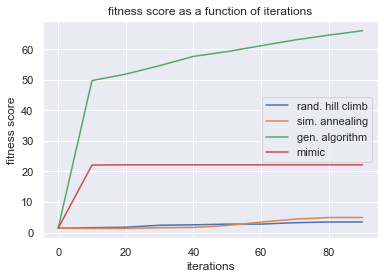

In [16]:
make_plot(x_values=iters, 
          y_values_dict={'rand. hill climb':rhc_iter_means,
                         'sim. annealing':sa_iter_means,
                         'gen. algorithm':ga_iter_means,
                         'mimic':mimic_iter_means
                        },
          x_label='iterations',
          y_label='fitness score')

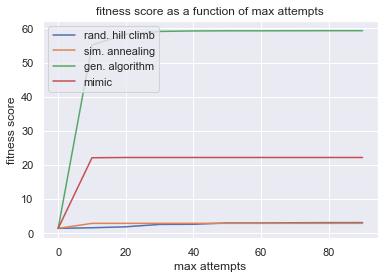

In [17]:
make_plot(x_values=attempts, 
          y_values_dict={'rand. hill climb':rhc_attempts_means,
                         'sim. annealing':sa_attempts_means,
                         'gen. algorithm':ga_attempts_means,
                         'mimic':mimic_attempts_means
                        },
          x_label='max attempts',
          y_label='fitness score')

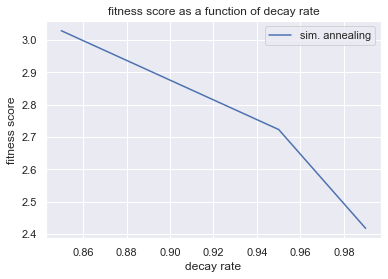

In [18]:
make_plot(x_values=decay_rates, 
          y_values_dict={'sim. annealing':sa_decay_means},
          x_label='decay rate',
          y_label='fitness score')

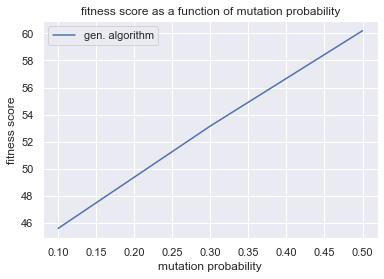

In [19]:
make_plot(x_values=mutation_probs, 
          y_values_dict={'gen. algorithm':ga_mutation_prob_means},
          x_label='mutation probability',
          y_label='fitness score')

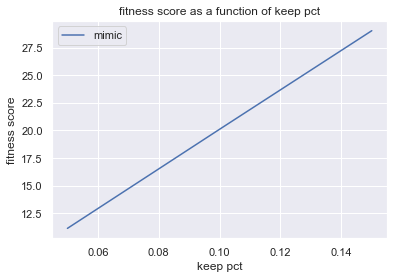

In [20]:
make_plot(x_values=keep_pcts, 
          y_values_dict={'mimic':mimic_keep_pct_means},
          x_label='keep pct',
          y_label='fitness score')

## Performance on problems of different sizes based on "best" parameters

In [21]:
problem_sizes = list(range(10, 101, 10))

In [27]:
%%time
rhc_best_results = []
rhc_times = []
sa_best_results = []
sa_times = []
ga_best_results = []
ga_times = []
mimic_best_results = []
mimic_times = []

for problem_size in problem_sizes:
    problem_fit = mlrose_hiive.DiscreteOpt(length=problem_size, fitness_fn=fitness_fn)
    
    t_start = time()
    _, best_fitness, _ = mlrose_hiive.random_hill_climb(problem=problem_fit,
                                                        max_iters=40,
                                                        max_attempts=10,
                                                        curve=False,
                                                        random_state=2020)
    rhc_best_results.append(best_fitness)
    rhc_times.append(time() - t_start)
    
    t_start = time()
    _, best_fitness, _ = mlrose_hiive.simulated_annealing(problem=problem_fit,
                                                          max_iters=40,
                                                          max_attempts=10,
                                                          schedule=mlrose_hiive.GeomDecay(init_temp=1.0, 
                                                                                          decay=0.8, 
                                                                                          min_temp=0.001),
                                                          curve=False,
                                                          random_state = 2020)
    sa_best_results.append(best_fitness)
    sa_times.append(time() - t_start)
    
    t_start = time()
    _, best_fitness, _ = mlrose_hiive.genetic_alg(problem_fit,
                                                  pop_size=problem_size,
                                                  max_iters=100,
                                                  max_attempts=10,
                                                  mutation_prob=0.5,
                                                  curve=False,
                                                  random_state = 2020)
    ga_best_results.append(best_fitness)
    ga_times.append(time() - t_start)
    
    t_start = time()
    _, best_fitness, _ = mlrose_hiive.mimic(problem_fit,
                                            pop_size=problem_size,
                                            max_iters=10,
                                            max_attempts=10,
                                            keep_pct=0.15,
                                            curve=False,
                                            random_state = 2020)
    
    mimic_best_results.append(best_fitness)
    mimic_times.append(time() - t_start)

CPU times: user 4min 15s, sys: 1.32 s, total: 4min 16s
Wall time: 5min 58s


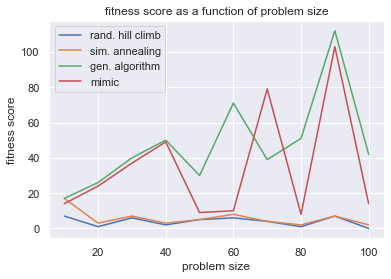

In [28]:
make_plot(x_values=problem_sizes, 
          y_values_dict={'rand. hill climb':rhc_best_results,
                         'sim. annealing':sa_best_results,
                         'gen. algorithm':ga_best_results,
                         'mimic':mimic_best_results
                        },
          x_label='problem size',
          y_label='fitness score')

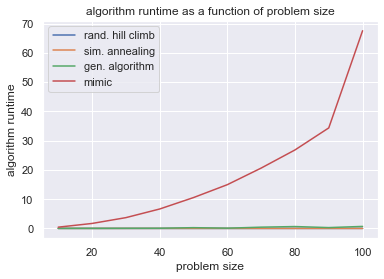

In [24]:
make_plot(x_values=problem_sizes, 
          y_values_dict={'rand. hill climb':rhc_times,
                         'sim. annealing':sa_times,
                         'gen. algorithm':ga_times,
                         'mimic':mimic_times
                        },
          x_label='problem size',
          y_label='algorithm runtime')